Códigos de correção de erro

In [1]:
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, amplitude_damping_error, phase_damping_error
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1-p_meas)])
    error_gate = depolarizing_error(p_gate, 1)
    error_gate2= error_gate.tensor(error_gate)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, 'measure')
    noise_model.add_all_qubit_quantum_error(error_gate, ['x'])
    noise_model.add_all_qubit_quantum_error(error_gate2, ['cx'])

    return noise_model

In [2]:
noise_model = get_noise(0.1,0.1)

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

def criar_circuito_repeticao(n, x):
    code_qubits = QuantumRegister(n, name='code_qubit')
    link_qubits = QuantumRegister(n-1, name='link_qubit')
    link_bits = ClassicalRegister(n-1, name='link_bit')
    code_bits = ClassicalRegister(n, name='code_bit')

    qc = QuantumCircuit(link_qubits, code_qubits, link_bits, code_bits)
    #qc.x(4)
    if x == 1:
        qc.x(code_qubits)

    for i in range(n-1):
        qc.cx(code_qubits[i], link_qubits[i])
        qc.cx(code_qubits[i+1], link_qubits[i])

    qc.barrier()

    for i in range(n-1):
        qc.measure(link_qubits[i], link_bits[i])

    ###################### 
    #CORRECAO
    for i in range(n):
        if i == 0:
            mask = 1
        elif i == n-1:
            mask = 1 << (n-2)
        else:
            mask = int('0'*(n-1-i) + '11'+'0'*(i-1),2)
        qc.x(code_qubits[i]).c_if(link_bits, mask)
    ######################

    qc.barrier()
    for i in range(n):
        qc.measure(code_qubits[i], code_bits[i])

    return qc

n=3
qc0 = criar_circuito_repeticao(n,0)
qc1 = criar_circuito_repeticao(n,1)

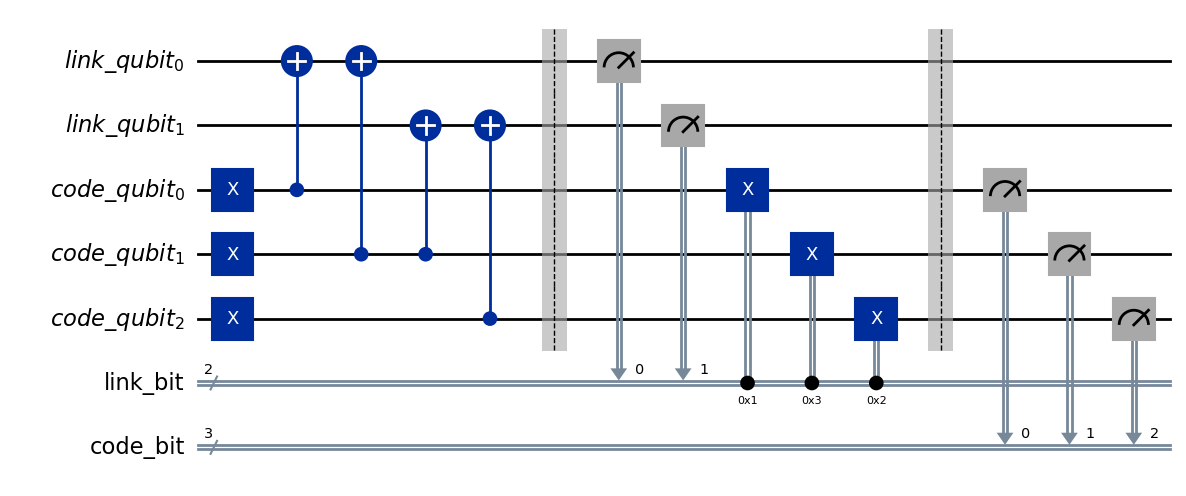

In [4]:
qc1.draw("mpl")

In [5]:
from qiskit import transpile
from qiskit_aer import AerSimulator
simulador_aer = AerSimulator()

qc_t = transpile([qc0], backend=simulador_aer)
result0 = simulador_aer.run(qc_t, shots=100000,noise_model=noise_model).result().get_counts()

qc_t = transpile([qc1], backend=simulador_aer)
result1 = simulador_aer.run(qc_t, shots=100000,noise_model=noise_model).result().get_counts()

In [6]:
import math
def calcular_porcentagens(resultados,n):
    total_elementos = sum(resultados.values())
    elementos_0s = 0
    elementos_1s = 0

    for key, count in resultados.items():
        primeiros_digitos = key.split()[0]
        num_0s = primeiros_digitos.count('0')
        num_1s = primeiros_digitos.count('1')
        
        if num_0s >= (math.floor(n/2)+1):
            elementos_0s += count
        if num_1s >= (math.floor(n/2)+1):
            elementos_1s += count

    porcentagem_0s = (elementos_0s / total_elementos) * 100
    porcentagem_1s = (elementos_1s / total_elementos) * 100
    
    return porcentagem_0s, porcentagem_1s

In [7]:
calcular_porcentagens(result0,n)

(87.053, 12.947000000000001)